Перед запуском убедитесь, что в корне проекта есть файл .env и в нем заполнены выданные вам креды подключения к базам данных и хранилищу

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
from dotenv import load_dotenv, find_dotenv
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# подгружаем .env
load_dotenv()

True

In [4]:
# Считываем все креды
dst_host = os.environ.get('DB_DESTINATION_HOST')
dst_port = os.environ.get('DB_DESTINATION_PORT')
dst_username = os.environ.get('DB_DESTINATION_USER')
dst_password = os.environ.get('DB_DESTINATION_PASSWORD')
dst_db = os.environ.get('DB_DESTINATION_NAME')

In [5]:
# Создадим соединения
dst_conn = create_engine(f'postgresql://{dst_username}:{dst_password}@{dst_host}:{dst_port}/{dst_db}')

In [6]:
#Проверяем типы исходных данных:
query = f"""
    SELECT
        f.id AS flat_id,                 
        f.floor,              
        f.is_apartment,       
        f.kitchen_area,       
        f.living_area,        
        f.rooms,              
        f.studio,             
        f.total_area,         
        f.price,              
        f.building_id,          
        b.build_year,         
        b.building_type_int,  
        b.latitude,           
        b.longitude,          
        b.ceiling_height,     
        b.flats_count,        
        b.floors_total,       
        b.has_elevator   
    FROM flats AS f
    LEFT JOIN buildings AS b
    ON b.id = f.building_id
"""
data = pd.read_sql(query, dst_conn)
#Проверяем типы данных:
print(data.dtypes)

flat_id                int64
floor                  int64
is_apartment            bool
kitchen_area         float64
living_area          float64
rooms                  int64
studio                  bool
total_area           float64
price                  int64
building_id            int64
build_year             int64
building_type_int      int64
latitude             float64
longitude            float64
ceiling_height       float64
flats_count            int64
floors_total           int64
has_elevator            bool
dtype: object


Далее создаём таблицу "real_estate"  при помощи DAG на основе выгруженных типов данных. После этого работаем с "real_estate"

In [7]:
#Выгружаем весь датасет:
query = f"""
    SELECT
        flat_id,                 
        floor,              
        is_apartment,       
        kitchen_area,       
        living_area,        
        rooms,              
        studio,             
        total_area,         
        price,              
        building_id,          
        build_year,         
        building_type_int,  
        latitude,           
        longitude,          
        ceiling_height,     
        flats_count,        
        floors_total,       
        has_elevator   
    FROM real_estate
"""
data = pd.read_sql(query, dst_conn)


In [8]:
#Проверяем типы данных после загрузки в локальную таблицу:
col_types = data.dtypes
print(col_types)

flat_id                int64
floor                  int64
is_apartment            bool
kitchen_area         float64
living_area          float64
rooms                  int64
studio                  bool
total_area           float64
price                  int64
building_id            int64
build_year             int64
building_type_int      int64
latitude             float64
longitude            float64
ceiling_height       float64
flats_count            int64
floors_total           int64
has_elevator            bool
dtype: object


In [9]:
# Проверяем датасет на наличие дубликатов
def find_duplicates(data):
    feature_cols = data.columns.drop('flat_id').tolist()
    is_duplicated_features = data.duplicated(subset=feature_cols, keep=False)
    n_rows_total = data.shape[0]
    n_rows_duplicated = is_duplicated_features.sum()
    print(f'Общее количество записей в таблице: {n_rows_total}')
    print(f"Количество дублирующихся строк за исключением 'id' и 'flat_id': {n_rows_duplicated}")
    print(f"Доля дублирующихся строк:{n_rows_duplicated/n_rows_total: 0.2f}")

find_duplicates(data)

Общее количество записей в таблице: 141362
Количество дублирующихся строк за исключением 'id' и 'flat_id': 17425
Доля дублирующихся строк: 0.12


In [10]:
# Убираем дубликаты:
def remove_duplicates(data):
    feature_cols = data.columns.drop('flat_id').tolist()
    is_duplicated_features = data.duplicated(subset=feature_cols, keep=False)
    data = data[~is_duplicated_features].reset_index(drop=True)
    return data

data = remove_duplicates(data)
find_duplicates(data)   # Проверяем датасет на наличие дубликатов

Общее количество записей в таблице: 123937
Количество дублирующихся строк за исключением 'id' и 'flat_id': 0
Доля дублирующихся строк: 0.00


In [11]:
# Проверяем пропущенные значения:
def find_missing_vals(data):
    cols_with_nans = data.isnull().sum()
    print(f"Количество пропущенных значений:\n{cols_with_nans}")
    cols_with_nans = cols_with_nans[cols_with_nans > 0].index
    print(f"Столбцы с пропущенными значениями:\n{cols_with_nans}")
    print(f"В датасете отсутствуют пропущенные значения: {len(cols_with_nans)==0}")

find_missing_vals(data)

Количество пропущенных значений:
flat_id              0
floor                0
is_apartment         0
kitchen_area         0
living_area          0
rooms                0
studio               0
total_area           0
price                0
building_id          0
build_year           0
building_type_int    0
latitude             0
longitude            0
ceiling_height       0
flats_count          0
floors_total         0
has_elevator         0
dtype: int64
Столбцы с пропущенными значениями:
Index([], dtype='object')
В датасете отсутствуют пропущенные значения: True


In [12]:
# Проверяем уникальные значения
unique_vals = data.nunique()
print(f"\nUnique values:\n{unique_vals}")


Unique values:
flat_id              123937
floor                    56
is_apartment              2
kitchen_area           1008
living_area            2290
rooms                    14
studio                    1
total_area             3288
price                  7968
building_id           24261
build_year              118
building_type_int         7
latitude              15646
longitude             15206
ceiling_height           76
flats_count             706
floors_total             64
has_elevator              2
dtype: int64


In [13]:
# разделяем столбцы по типам данных. Категориальные пока отдельно не выносим
index_cols = ['flat_id', 'building_id']
binary_cols = col_types[col_types == 'bool'].index.tolist()
num_cols = col_types[(col_types == 'int64') | (col_types == 'float64')].index.tolist()
num_cols = [i for i in num_cols if i not in index_cols]

In [14]:
# Ознакамливаемся с описательной статистикой датасета:
description = data.describe()
print(description)

             flat_id          floor   kitchen_area    living_area  \
count  123937.000000  123937.000000  123937.000000  123937.000000   
mean    70571.303614       7.443806       8.936198      30.931329   
std     40930.690829       5.689226       5.176653      23.411369   
min         0.000000       1.000000       0.000000       0.000000   
25%     35107.000000       3.000000       6.100000      19.000000   
50%     70683.000000       6.000000       8.700000      29.400000   
75%    106110.000000      10.000000      10.200000      41.000000   
max    141361.000000      56.000000     203.000000     700.000000   

               rooms     total_area         price    building_id  \
count  123937.000000  123937.000000  1.239370e+05  123937.000000   
mean        2.119416      61.728834  1.923365e+07   13981.186530   
std         0.987205      39.314205  6.890131e+07    6962.401326   
min         1.000000      11.000000  1.100000e+01       1.000000   
25%         1.000000      39.099998  8

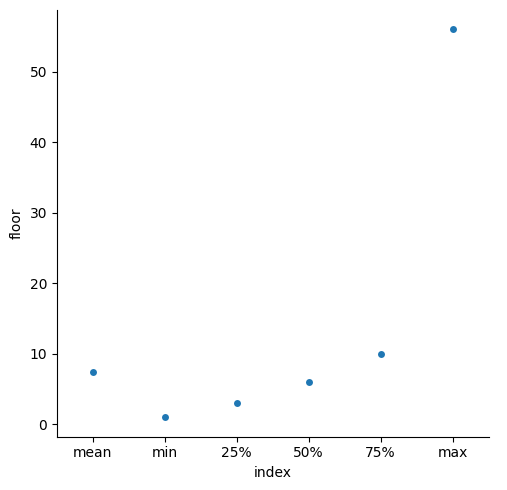

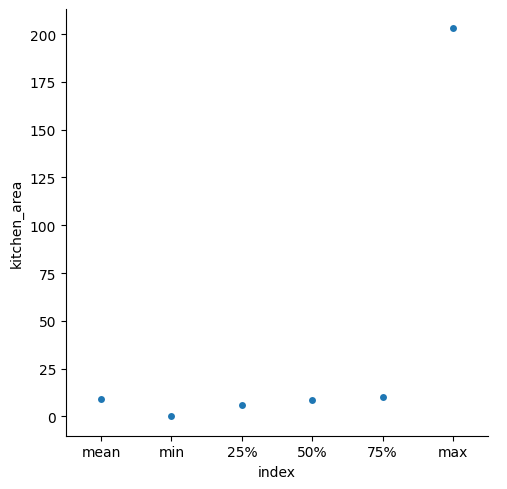

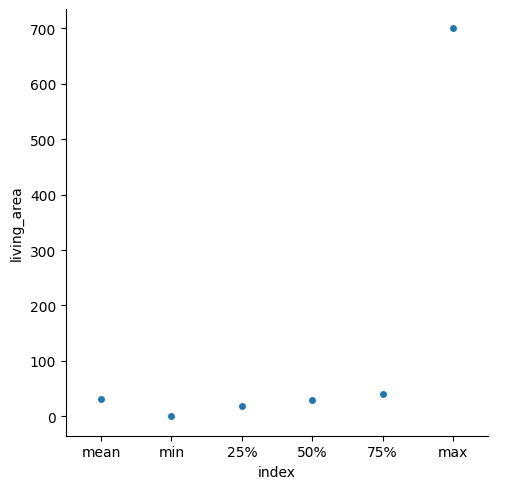

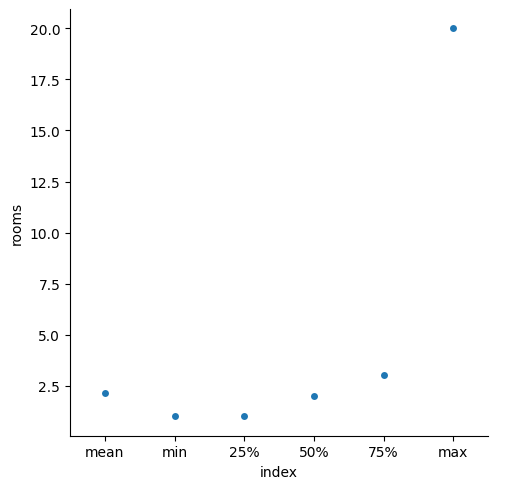

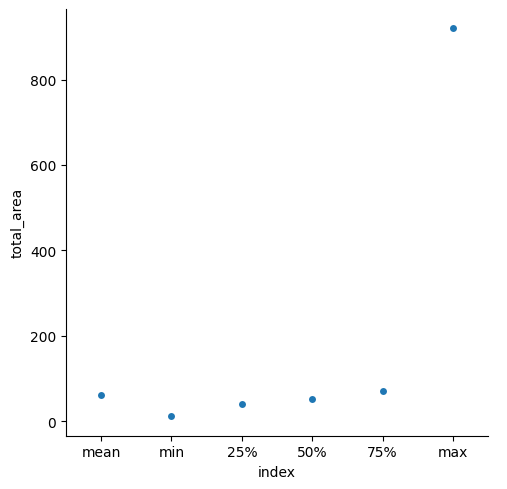

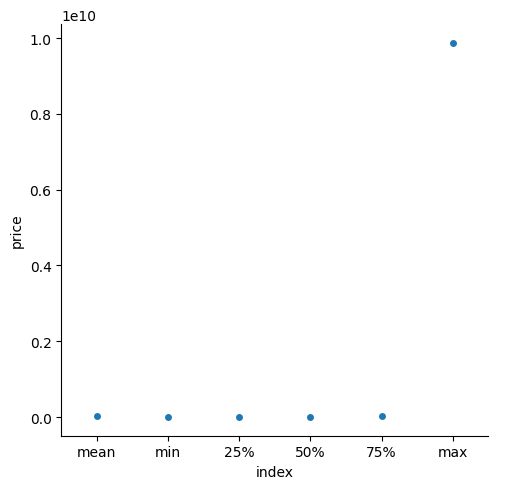

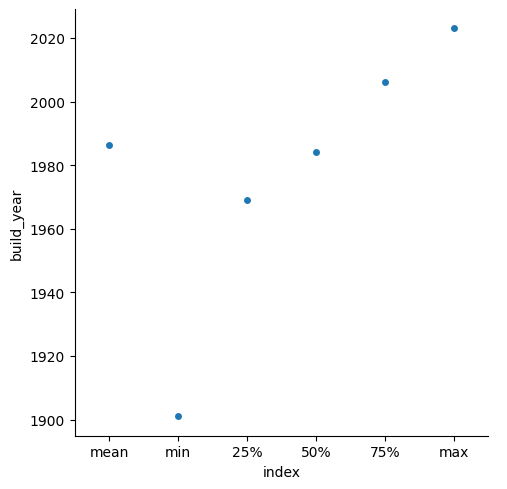

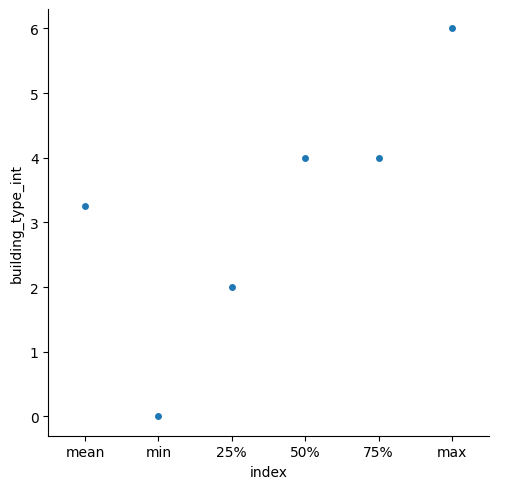

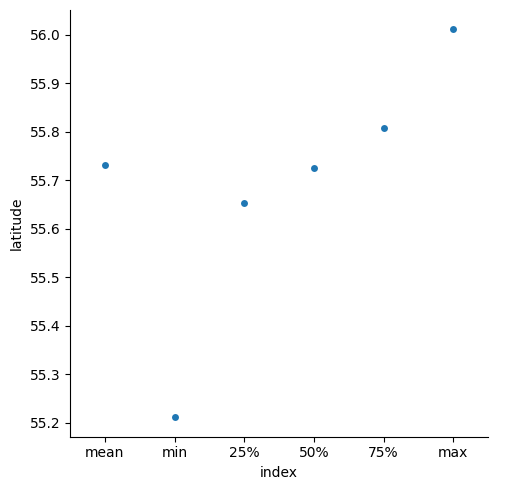

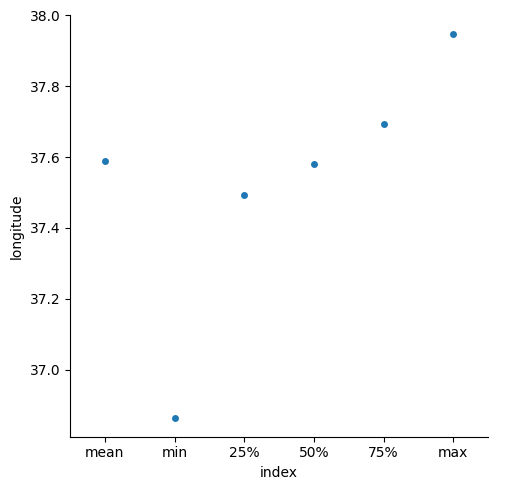

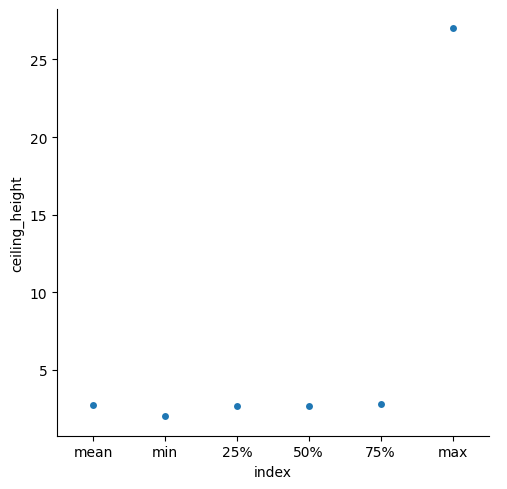

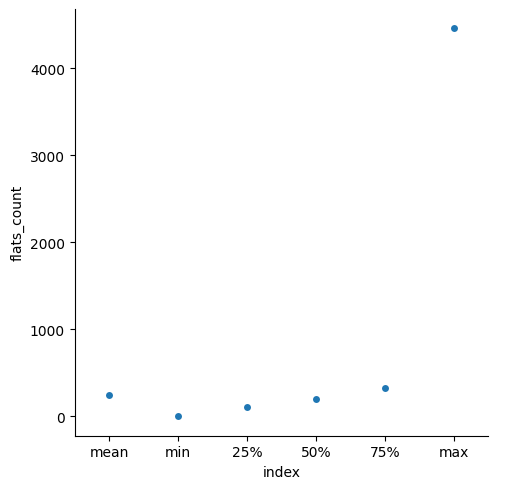

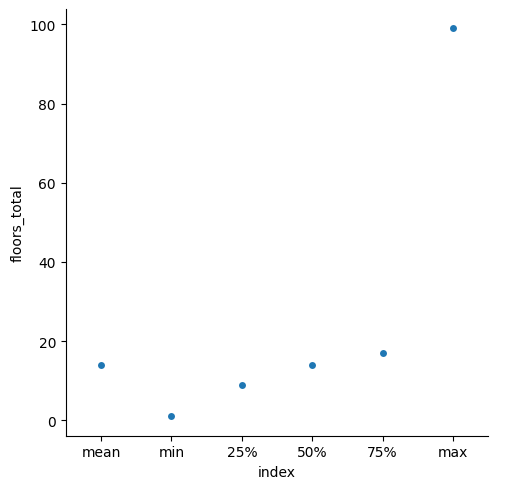

In [15]:
def plot_description(description, num_cols):
    description = description.reset_index(inplace=False)
    description = description[
          (description['index'] != 'count')
        & (description['index'] != 'std')
        ]

    for col in num_cols:  
        sns.catplot(data=description, x='index', y=col, kind='strip')  
        plt.show()

plot_description(description, num_cols)

In [16]:
# Убираем выбросы:
def remove_outliers(data):
    num_cols = data.select_dtypes(['float', 'int']).columns
    threshold = 1.5
    potential_outliers = pd.DataFrame()

    for col in num_cols:
        Q1 = data[col].quantile(q=0.25, interpolation='linear')
        Q3 = data[col].quantile(q=0.75, interpolation='linear')
        IQR = Q3 - Q1 
        margin = threshold*IQR
        lower = Q1 - margin
        upper = Q3 + margin
        potential_outliers[col] = ~data[col].between(lower, upper)

    outliers = potential_outliers.any(axis=1)
    return data.loc[~outliers, :]

data = remove_outliers(data)

In [17]:
# Проверяем статистику датасета после того, как убрали выбросы:
description = data.describe()
print(description)

             flat_id         floor  kitchen_area   living_area         rooms  \
count   97178.000000  97178.000000  97178.000000  97178.000000  97178.000000   
mean    69637.432227      6.723096      8.082964     27.532788      1.942827   
std     41217.149101      4.501015      2.985974     14.325563      0.813515   
min         0.000000      1.000000      0.000000      0.000000      1.000000   
25%     33547.250000      3.000000      6.000000     19.000000      1.000000   
50%     69618.500000      6.000000      8.400000     28.400000      2.000000   
75%    104979.250000      9.000000     10.000000     36.000000      3.000000   
max    141361.000000     20.000000     16.300000     74.000000      5.000000   

         total_area         price   building_id    build_year  \
count  97178.000000  9.717800e+04  97178.000000  97178.000000   
mean      51.470987  1.176918e+07  13140.837566   1984.048293   
std       16.101386  4.467336e+06   6425.602609     19.321556   
min       11.000000

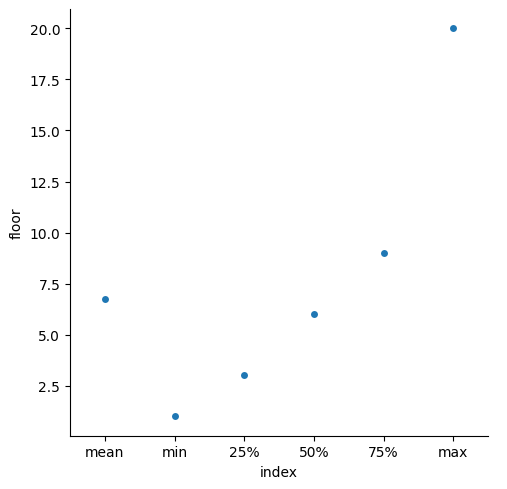

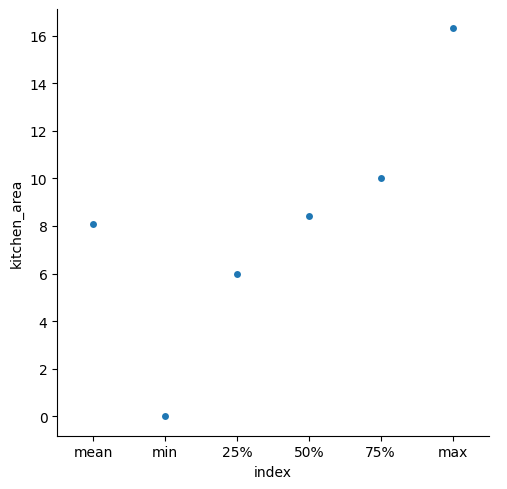

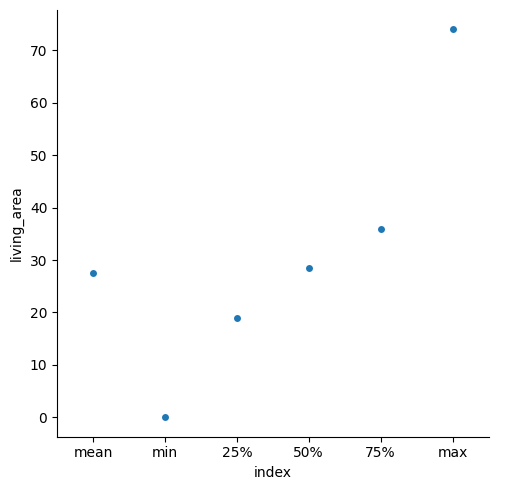

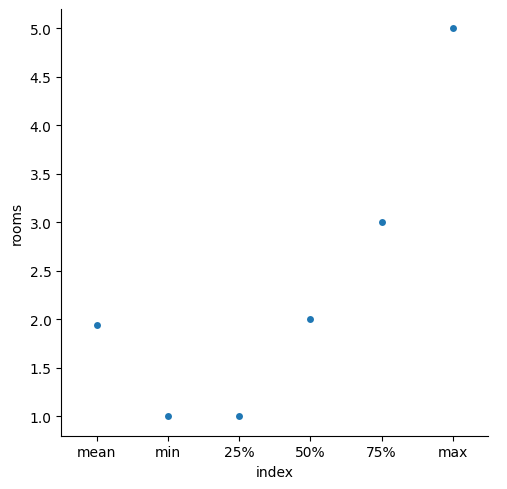

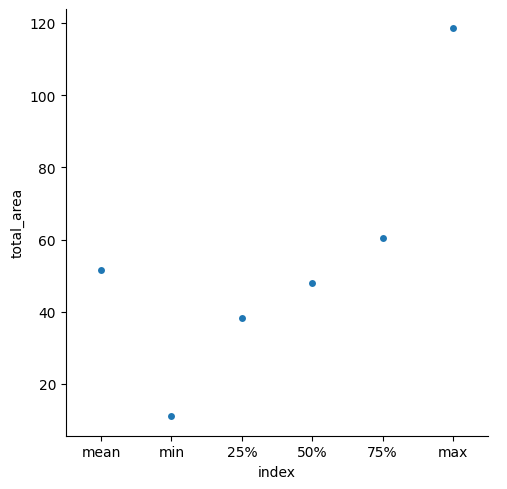

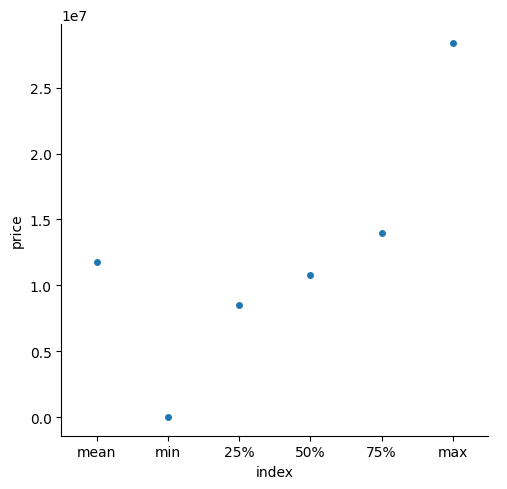

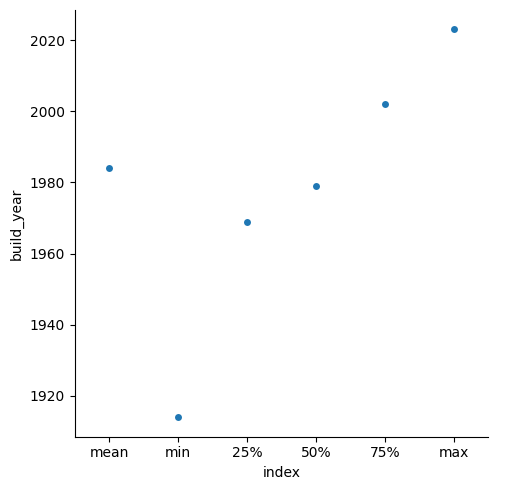

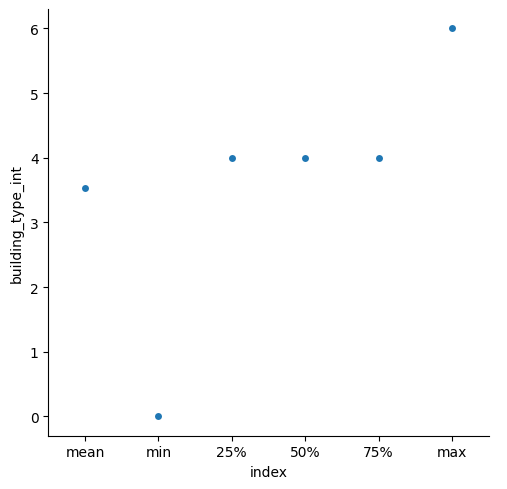

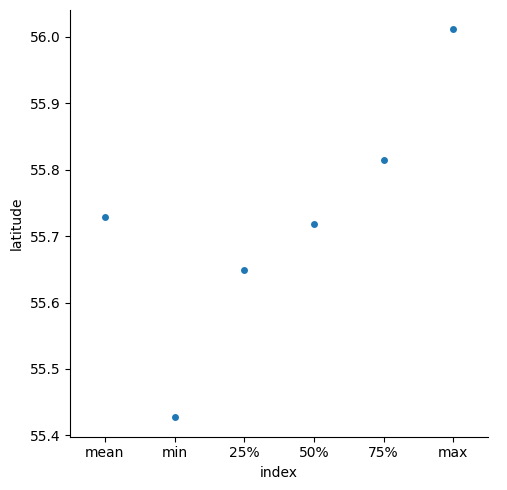

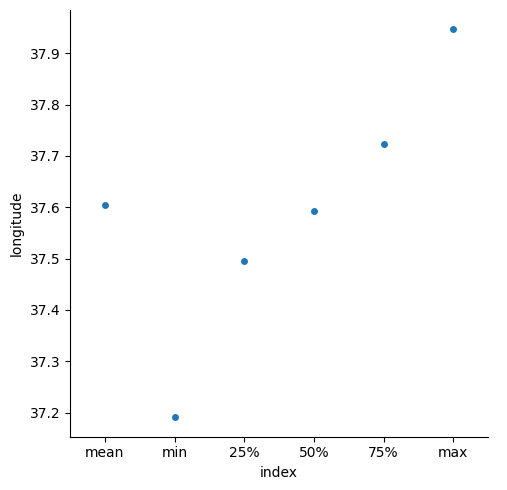

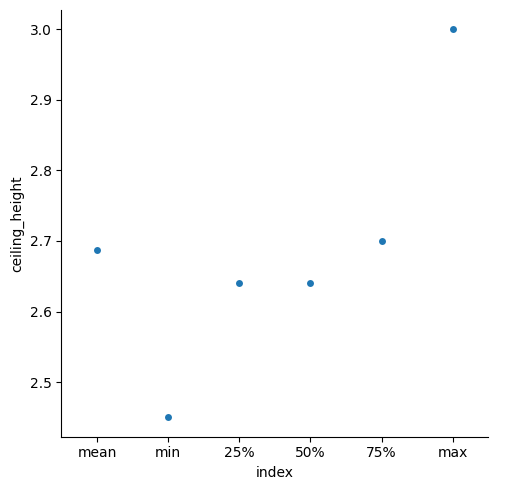

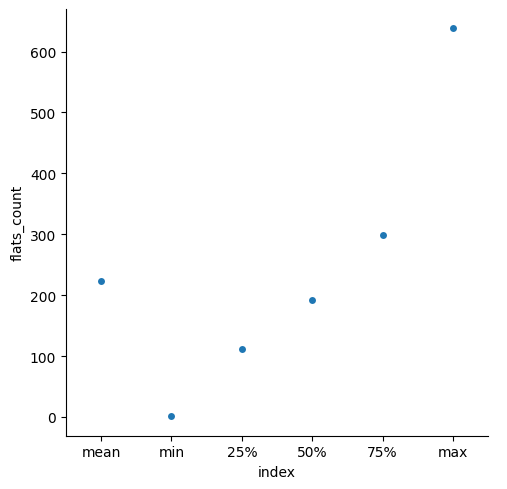

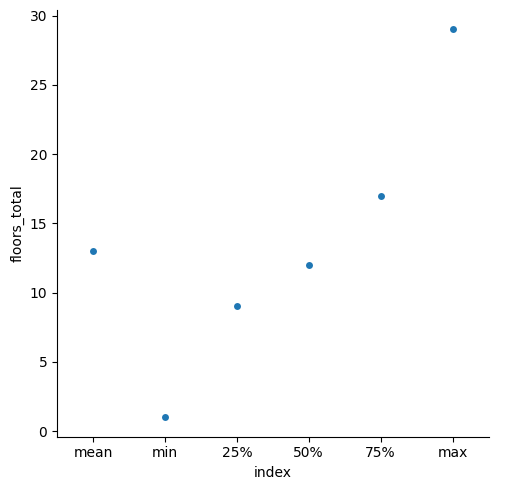

In [18]:
# Проверяем статистику датасета после того, как убрали выбросы:
plot_description(description, num_cols)

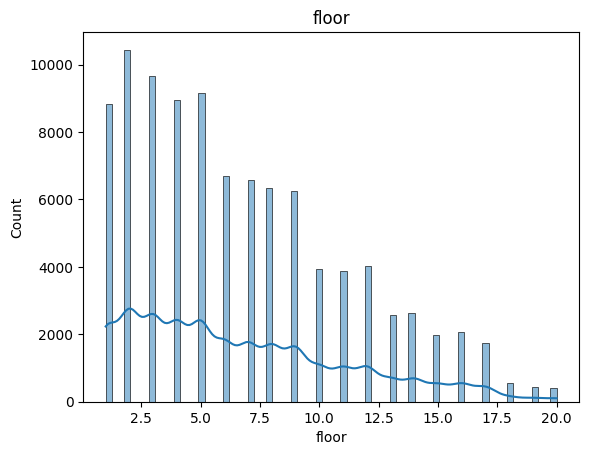

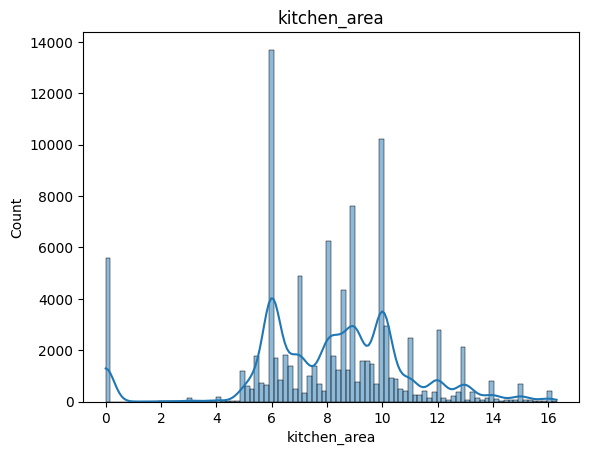

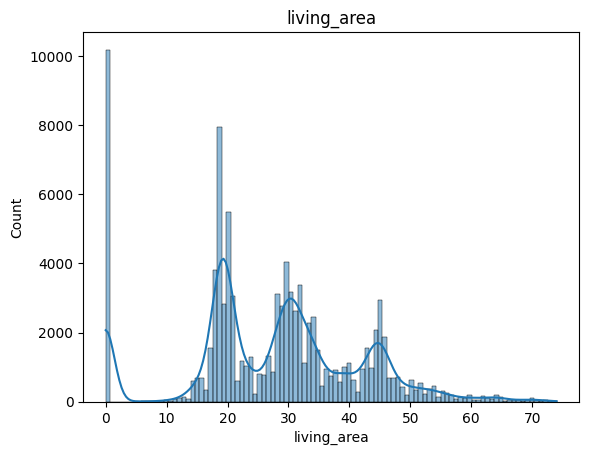

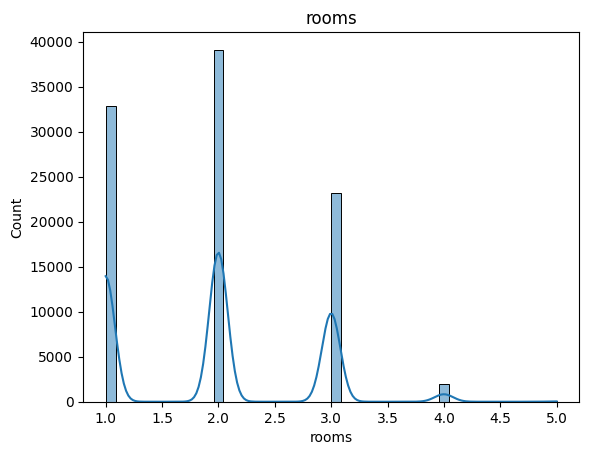

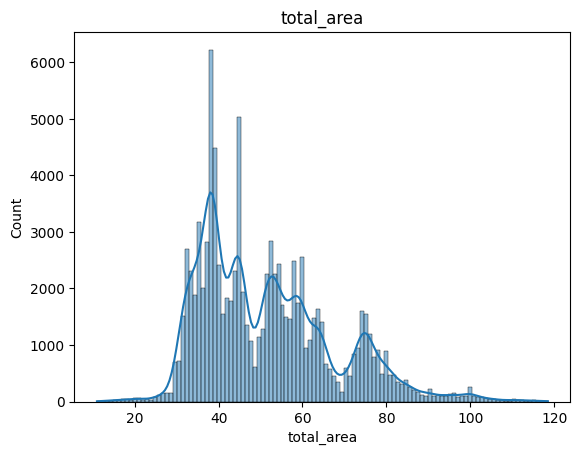

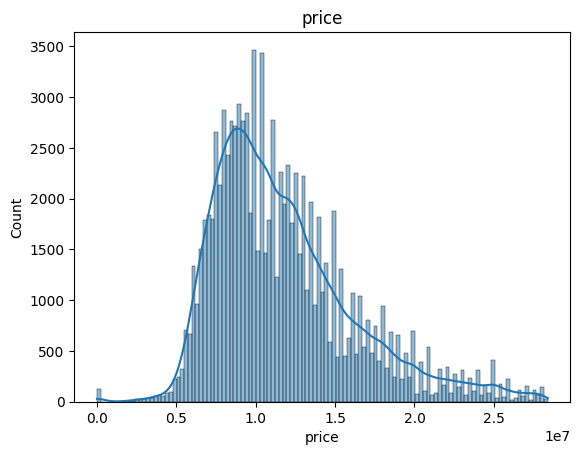

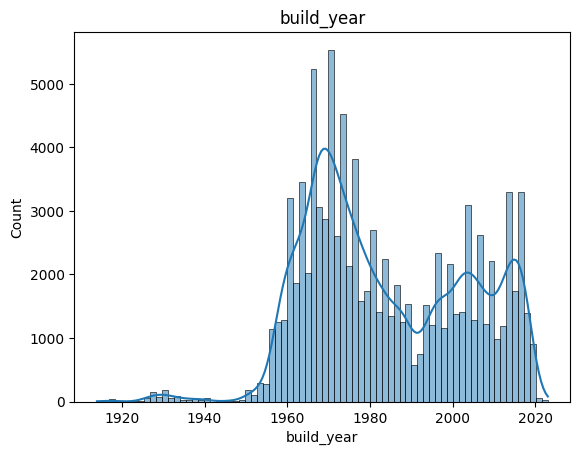

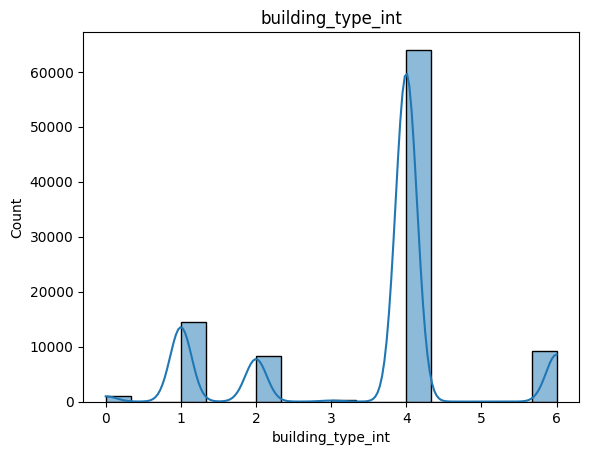

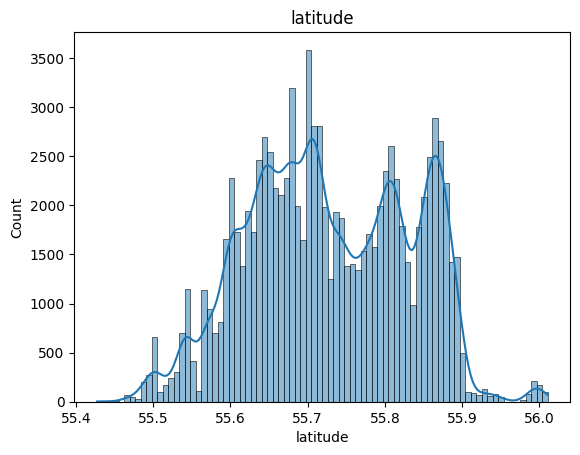

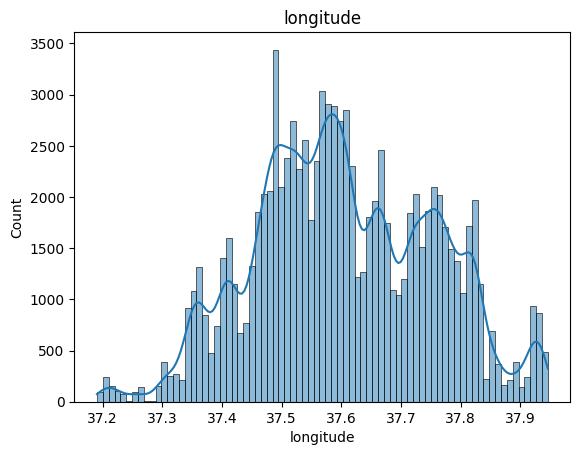

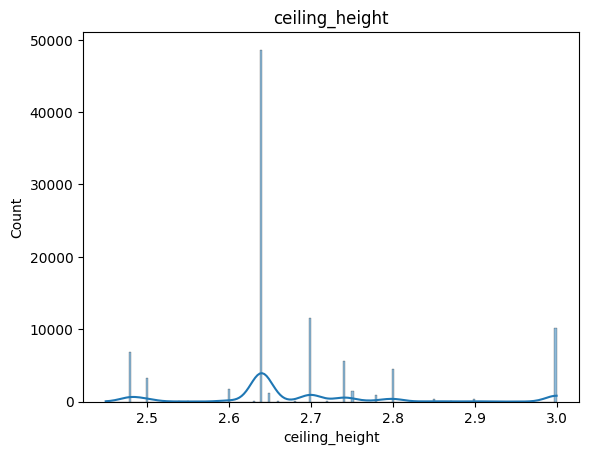

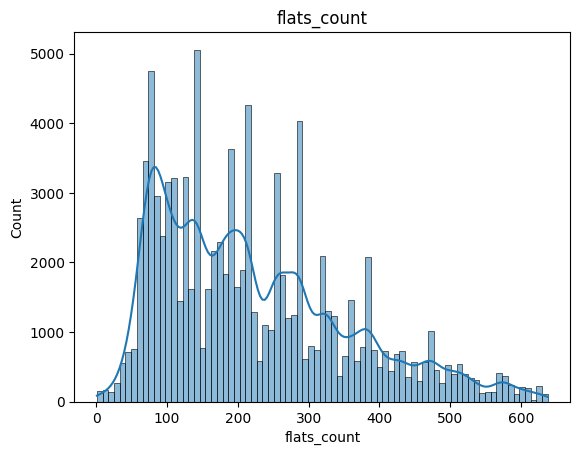

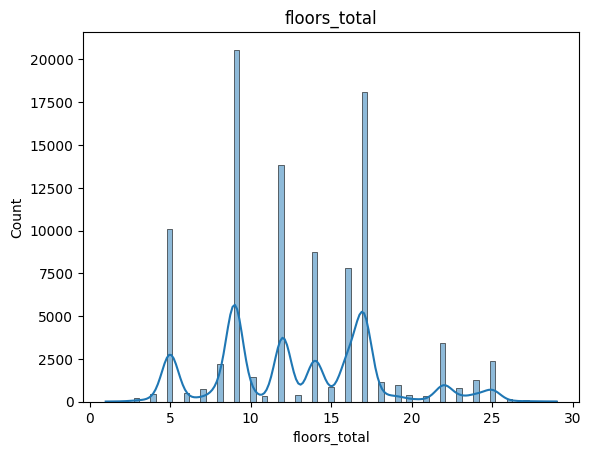

In [19]:
# проверяем распределения:
def plot_hists(data, num_cols):
    for column in num_cols:
        plt.figure()
        sns.histplot(data[column], kde=True)  # Use sns.distplot for older versions
        plt.title(column)
        plt.show()

plot_hists(data, num_cols)

В данных наблюдаются аномалии: квартиры с нулевой жилой площадью или нулевой площадью кухни, однако, при этом общая площадь не демонстрирует подобных аномалий. В связи с тем, что пока не ясно, какие признаки имеют набольшее влияние на целевую переменную, на данном этапе предобработки фильтрация по площади производиться не будет. Также, ряд квартир продаётся по аномально низкой цене. 

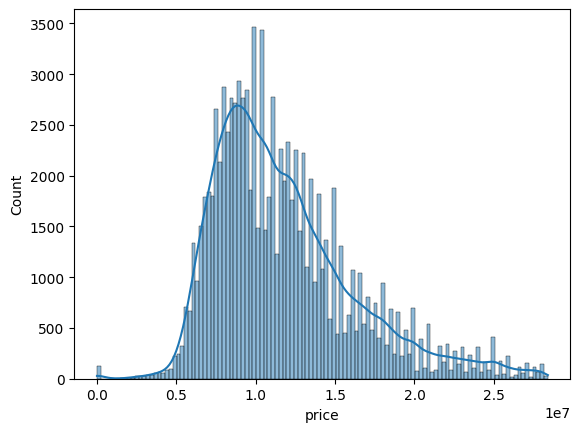

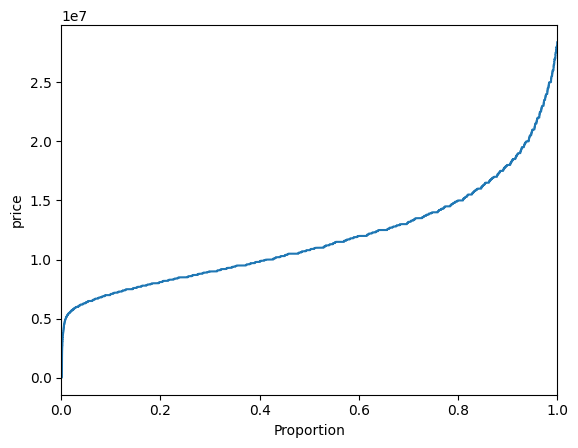

In [20]:
sns.histplot(data["price"], kde=True)
plt.show()
sns.ecdfplot(data=data, y="price")
plt.show()